<a href="https://colab.research.google.com/github/shpotes/traffic-counter/blob/loss/notebooks/loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---


#◢ Verify Correct Runtime Settings

**<font color='#FF000'> IMPORTANT </font>**

In the "Runtime" menu for the notebook window, select "Change runtime type." Ensure that the following are selected:
* Runtime Type = Python 3
* Hardware Accelerator = GPU 


#◢ Git clone and install Faster R-CNN

In [1]:
!git clone https://github.com/shpotes/traffic-counter
%cd traffic-counter/notebooks

fatal: destination path 'traffic-counter' already exists and is not an empty directory.
/content/traffic-counter/notebooks


#◢ Setup

In [2]:
!pip install -r ../requirements.txt

In [1]:
import sys
import os
import json
from itertools import groupby
from operator import itemgetter
from typing import List, Tuple, Dict

import gin
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

sys.path.append('..')

from vehicle_nowcasting.data.data_loader import build_source_from_metadata, make_dataset, generate_anchors
from vehicle_nowcasting.data.generate_anchors import generate_anchors as gen_anch
from vehicle_nowcasting.utils import iou, plot_bb, change_box_order

%matplotlib inline

##◢ Load metadata

In [2]:
main_dir = '..'
data_dir = os.path.join(main_dir, 'data')
metadata = pd.read_csv('../data/metadata.csv')
label_map = json.load(open('../data/label_map.json', 'r'))

In [3]:
sources = build_source_from_metadata(metadata,
                                     label_map,
                                     data_dir)

In [4]:
sources[:2]

[('../data/train/15-02-15-20:17.jpg',
  [(1, 225, 117, 411, 281),
   (3, 335, 212, 456, 329),
   (3, 555, 140, 607, 210),
   (4, 470, 211, 553, 307),
   (4, 442, 138, 519, 202),
   (4, 24, 238, 147, 334),
   (4, 166, 176, 244, 258),
   (4, 388, 110, 435, 167),
   (4, 505, 96, 557, 149),
   (1, 436, 39, 528, 126),
   (3, 546, 66, 593, 106),
   (3, 615, 59, 663, 99)]),
 ('../data/train/33.09-14-17:43.jpg',
  [(3, 378, 288, 579, 474),
   (3, 271, 7, 346, 58),
   (3, 558, 191, 704, 307),
   (3, 555, 132, 695, 214),
   (3, 405, 65, 498, 126),
   (3, 302, 75, 393, 135),
   (3, 227, 32, 293, 72),
   (3, 213, 1, 268, 26),
   (3, 71, 16, 120, 58),
   (2, 8, 39, 101, 155),
   (5, 83, 57, 109, 96),
   (5, 148, 143, 187, 203),
   (5, 150, 108, 191, 161),
   (5, 349, 373, 443, 477),
   (5, 310, 437, 384, 480)])]

In [5]:
ds = make_dataset(sources)

W0910 12:40:37.301612 140215290308416 deprecation.py:323] From /home/santiago/anaconda3/envs/CV/lib/python3.6/site-packages/tensorflow_core/python/ops/array_ops.py:1486: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


W0910 12:40:39.742943 140215290308416 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


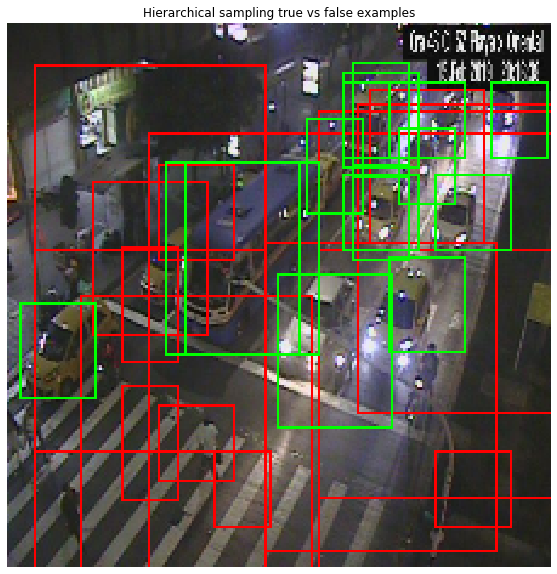

In [6]:
tensor = next(iter(ds))
anchors = tensor[1].numpy()
img = tensor[0].numpy()[:, :]

neg = anchors[anchors[:, 0] == -1]
pos = anchors[anchors[:, 0] != -1]

img = plot_bb(img, neg, (255, 0, 0), 1)
img = plot_bb(img, pos, (0, 255, 0), 1)

plt.figure(figsize = (10,10))
plt.imshow(img)
plt.axis('off')
plt.title('Hierarchical sampling true vs false examples');

In [7]:
tensor = next(iter(ds))

In [8]:
_, anchor_bbox, ground_truth = tensor

In [9]:
anchors = tf.cast(tf.constant(gen_anch(base_size=4,
                                       ratios=[1, 1.25, 1.5, 1.75, 2],
                                       scales=2 ** np.arange(3, 10))), tf.int32)
W = 12
H = 12
k = len(anchors)

dx = int(np.ceil(224 / W)) * tf.range(W, dtype=tf.int32)
dy = int(np.ceil(224 / H)) * tf.range(H, dtype=tf.int32)

dy = tf.reshape(dy, (-1, 1, 1))
dx = tf.reshape(dx, (1, -1, 1))

dx = tf.concat([dx, tf.zeros((1, W, 1), dtype=tf.int32)], axis=-1)
dy = tf.concat([tf.zeros((H, 1, 1), dtype=tf.int32), dy], axis=-1)

reference = tf.reshape(dx + dy, (1, H, W, 1, 2))
reference = tf.concat([reference, reference], axis=-1)

anchors = reference + tf.reshape(anchors, (1, 1, 1, k, 4))
anchors = tf.transpose(anchors, [0, 2, 1, 3, 4])

In [10]:
print(anchors[0, 0, 0, 0])
print(anchors[0, 10, 0, 0])
print(anchors[0, 0, 10, 0])

tf.Tensor([-14 -14  17  17], shape=(4,), dtype=int32)
tf.Tensor([176 -14 207  17], shape=(4,), dtype=int32)
tf.Tensor([-14 176  17 207], shape=(4,), dtype=int32)


In [11]:
cond = tf.equal(tf.reshape(anchor_bbox[:, 1:], (-1, 1, 1, 1, 4)), anchors)
cond = tf.reduce_all(cond, axis=-1)
anchor_map = tf.cast(tf.where(cond), tf.int32)

#anchor_map # De aqui sacaré los k

In [12]:
anchor_map

<tf.Tensor: id=459, shape=(32, 4), dtype=int32, numpy=
array([[ 0,  5,  5, 22],
       [ 1,  9,  6,  7],
       [ 2,  4, 11, 15],
       [ 3,  8,  2, 21],
       [ 4,  7,  7, 15],
       [ 5,  9,  8,  1],
       [ 6, 10,  9,  0],
       [ 7, 10,  4,  0],
       [ 8,  3,  6,  0],
       [ 9,  8,  6, 21],
       [10,  6,  9,  7],
       [11,  5,  5,  8],
       [12,  8,  2,  7],
       [13,  8,  6,  1],
       [14,  6, 11, 22],
       [15,  6,  4,  2],
       [16,  8,  2, 28],
       [17,  8,  2,  0],
       [18,  1,  8, 28],
       [19,  8,  6,  7],
       [20,  8,  2,  7],
       [21,  9,  2,  0],
       [22, 10, 10, 24],
       [23,  8,  4,  0],
       [24,  5,  5, 14],
       [25,  5,  5,  8],
       [26, 11,  2,  0],
       [27,  3,  5,  7],
       [28,  9,  8,  2],
       [29,  5,  3,  8],
       [30,  5,  8,  9],
       [31,  1,  7,  7]], dtype=int32)>

In [13]:
gt_pointer = anchor_bbox[:, :1]
p_raw = tf.cast(gt_pointer != -1, tf.int32)

In [14]:
p_loc_raw = tf.cast(anchor_map[:, -1:] * 2, tf.int32) + p_raw
p_loc = tf.concat([anchor_map[:, 1:-1], p_loc_raw], axis=-1)
p_loc

<tf.Tensor: id=479, shape=(32, 3), dtype=int32, numpy=
array([[ 5,  5, 45],
       [ 9,  6, 15],
       [ 4, 11, 30],
       [ 8,  2, 43],
       [ 7,  7, 31],
       [ 9,  8,  2],
       [10,  9,  0],
       [10,  4,  1],
       [ 3,  6,  0],
       [ 8,  6, 42],
       [ 6,  9, 14],
       [ 5,  5, 17],
       [ 8,  2, 15],
       [ 8,  6,  2],
       [ 6, 11, 44],
       [ 6,  4,  4],
       [ 8,  2, 57],
       [ 8,  2,  1],
       [ 1,  8, 56],
       [ 8,  6, 15],
       [ 8,  2, 15],
       [ 9,  2,  1],
       [10, 10, 48],
       [ 8,  4,  1],
       [ 5,  5, 28],
       [ 5,  5, 17],
       [11,  2,  0],
       [ 3,  5, 15],
       [ 9,  8,  4],
       [ 5,  3, 16],
       [ 5,  8, 18],
       [ 1,  7, 15]], dtype=int32)>

In [15]:
p_template = np.zeros((12, 12, 70))
p = tf.tensor_scatter_nd_update(p_template, p_loc, tf.ones(32)) ####### HERE

In [16]:
gt_mask = tf.cast(p_raw[:,0], tf.bool)#, gt_pointer)
pointers = tf.gather(gt_pointer, tf.where(gt_mask)[:, 0])[:, 0]
tf.gather(ground_truth, pointers)[:, 1:]

<tf.Tensor: id=506, shape=(16, 4), dtype=int32, numpy=
array([[ 72,  55, 131, 131],
       [150,  98, 176, 143],
       [139,  18, 168,  59],
       [107,  99, 145, 154],
       [177,  65, 193,  98],
       [ 72,  55, 131, 131],
       [139,  18, 168,  59],
       [139,  18, 168,  59],
       [139,  18, 168,  59],
       [150,  98, 176, 143],
       [139,  18, 168,  59],
       [174,  31, 189,  49],
       [141,  64, 165,  94],
       [ 72,  55, 131, 131],
       [ 53,  82,  78, 120],
       [  8, 111,  47, 156]], dtype=int32)>

In [17]:
ext_ground_truth = tf.concat([ground_truth, [[-1, 1, 2, 3, 4]]], axis=0)

In [18]:
_gt = tf.gather(ext_ground_truth,
                tf.where(tf.equal(-1, gt_pointer),
                         len(ground_truth) * tf.ones_like(gt_pointer),
                         gt_pointer ))[:, 0, 1:]

_gt = change_box_order(tf.cast(_gt, tf.float64))
_bb = change_box_order(tf.cast(anchor_bbox[:, 1:], tf.float64))

In [19]:
t_x = (_gt[:, 0] - _bb[:, 0]) / _bb[:, 2]
t_x = tf.reshape(t_x, (-1, 1))
t_y = (_gt[:, 1] - _bb[:, 1]) / _bb[:, 3]
t_y = tf.reshape(t_y, (-1, 1))
t_w = tf.math.log(_gt[:, 2] / _bb[:, 2])
t_w = tf.reshape(t_w, (-1, 1))
t_h = tf.math.log(_gt[:, 3] / _bb[:, 3])
t_h = tf.reshape(t_h, (-1, 1))
t_bbox = tf.concat([t_x, t_y, t_w, t_h], axis=-1)

In [20]:
t_loc_raw = tf.cast(anchor_map[:, -1:], tf.int32)
t_loc = tf.concat([anchor_map[:, 1:-1], t_loc_raw], axis=-1)

In [21]:
t_loc

<tf.Tensor: id=625, shape=(32, 3), dtype=int32, numpy=
array([[ 5,  5, 22],
       [ 9,  6,  7],
       [ 4, 11, 15],
       [ 8,  2, 21],
       [ 7,  7, 15],
       [ 9,  8,  1],
       [10,  9,  0],
       [10,  4,  0],
       [ 3,  6,  0],
       [ 8,  6, 21],
       [ 6,  9,  7],
       [ 5,  5,  8],
       [ 8,  2,  7],
       [ 8,  6,  1],
       [ 6, 11, 22],
       [ 6,  4,  2],
       [ 8,  2, 28],
       [ 8,  2,  0],
       [ 1,  8, 28],
       [ 8,  6,  7],
       [ 8,  2,  7],
       [ 9,  2,  0],
       [10, 10, 24],
       [ 8,  4,  0],
       [ 5,  5, 14],
       [ 5,  5,  8],
       [11,  2,  0],
       [ 3,  5,  7],
       [ 9,  8,  2],
       [ 5,  3,  8],
       [ 5,  8,  9],
       [ 1,  7,  7]], dtype=int32)>

In [22]:
t_template = np.zeros((12, 12, k, 4))
t = tf.tensor_scatter_nd_update(t_template, t_loc, t_bbox) ###### HERE

In [23]:
t.shape

TensorShape([12, 12, 35, 4])

In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Concatenate
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.vgg16 import VGG16

In [33]:
def RPN(inputs, k):
    x = Conv2D(256, kernel_size=(3, 3), 
               activation='relu',
               name='window')(inputs)
    cls = Conv2D(2 * k, kernel_size=(1, 1), name='cls_head')(x)
    reg = Conv2D(4 * k, kernel_size=(1, 1), name='reg_head')(x)
    return Concatenate()([cls, reg])

In [34]:
k = 35
inputs = Input(shape=(224, 224, 3))
backbone_model = VGG16(input_tensor=inputs,
                       weights='imagenet',
                       include_top=False)
x = backbone_model.layers[-5].output
model = Model(inputs=inputs, outputs=RPN(x, k))

In [35]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [38]:
def RPN_loss(k, y_true, y_pred):
    p_true = y_true[:, :, :, :(2 * k)]
    t_true = y_true[:, :, :, -(4 * k):]
    p_pred = y_pred[:, :, :, :(2 * k)]
    t_pred = y_pred[:, :, :, -(4 * k):]
    
    cls_loss = tf.math.reduce_sum(tf.keras.losses.binary_crossentropy(p_true, p_pred))
    reg_loss = tf.math.reduce_sum(p_true * tf.keras.losses.Huber()(t_true, t_pred))
    return cls_loss + reg_loss

In [39]:
adam = tf.optimizers.Adam(learning_rate=3e-4)
model.compile(optimizer=adam, loss=RPN_loss) # ?? 

In [40]:
def RPN_data(anchors, img, anchor_bbox, ground_truth):
    k = anchors.shape[3]
    
    cond = tf.equal(tf.reshape(anchor_bbox[:, 1:], (-1, 1, 1, 1, 4)), anchors)
    cond = tf.reduce_all(cond, axis=-1)
    anchor_map = tf.cast(tf.where(cond), tf.int32)
    
    gt_pointer = anchor_bbox[:, :1]
    p_raw = tf.cast(gt_pointer != -1, tf.int32)
    
    p_loc_raw = tf.cast(anchor_map[:, -1:] * 2, tf.int32) + p_raw
    p_loc = tf.concat([anchor_map[:, 1:-1], p_loc_raw], axis=-1)
    p_template = tf.zeros((12, 12, 70), dtype=tf.float64)
    
    p = tf.tensor_scatter_nd_update(p_template, p_loc, tf.ones(32, dtype=tf.float64))
    
    gt_mask = tf.cast(p_raw[:,0], tf.bool)#, gt_pointer)
    pointers = tf.gather(gt_pointer, tf.where(gt_mask)[:, 0])[:, 0]
    tf.gather(ground_truth, pointers)[:, 1:]
    
    ext_ground_truth = tf.concat([ground_truth, [[-1, 1, 2, 3, 4]]], axis=0)
    
    _gt = tf.gather(ext_ground_truth,
                tf.where(tf.equal(-1, gt_pointer),
                         len(ground_truth) * tf.ones_like(gt_pointer),
                         gt_pointer ))[:, 0, 1:]

    _gt = change_box_order(tf.cast(_gt, tf.float64))
    _bb = change_box_order(tf.cast(anchor_bbox[:, 1:], tf.float64))
    
    t_x = (_gt[:, 0] - _bb[:, 0]) / _bb[:, 2]
    t_x = tf.reshape(t_x, (-1, 1))
    t_y = (_gt[:, 1] - _bb[:, 1]) / _bb[:, 3]
    t_y = tf.reshape(t_y, (-1, 1))
    t_w = tf.math.log(_gt[:, 2] / _bb[:, 2])
    t_w = tf.reshape(t_w, (-1, 1))
    t_h = tf.math.log(_gt[:, 3] / _bb[:, 3])
    t_h = tf.reshape(t_h, (-1, 1))
    t_bbox = tf.concat([t_x, t_y, t_w, t_h], axis=-1)
    
    t_loc_raw = tf.cast(anchor_map[:, -1:], tf.int32)
    t_loc = tf.concat([anchor_map[:, 1:-1], t_loc_raw], axis=-1)
    
    t_template = tf.zeros((12, 12, k, 4), dtype=tf.float64)
    t = tf.tensor_scatter_nd_update(tensor=tf.cast(t_template, tf.float64), 
                                    indices=tf.cast(t_loc, tf.int32),
                                    updates=tf.cast(t_bbox, tf.float64))
    t = tf.reshape(t, (12, 12, -1))
    return img, tf.concat([p, t], axis=-1)

In [41]:
def precompute_ancors_position():
    anchors = tf.cast(tf.constant(gen_anch(base_size=4,
                                       ratios=[1, 1.25, 1.5, 1.75, 2],
                                       scales=2 ** np.arange(3, 10))), tf.int32)
    k = len(anchors)
    W = 12
    H = 12
    print(k)

    dx = int(np.ceil(224 / W)) * tf.range(W, dtype=tf.int32)
    dy = int(np.ceil(224 / H)) * tf.range(H, dtype=tf.int32)

    dy = tf.reshape(dy, (-1, 1, 1))
    dx = tf.reshape(dx, (1, -1, 1))

    dx = tf.concat([dx, tf.zeros((1, W, 1), dtype=tf.int32)], axis=-1)
    dy = tf.concat([tf.zeros((H, 1, 1), dtype=tf.int32), dy], axis=-1)

    reference = tf.reshape(dx + dy, (1, H, W, 1, 2))
    reference = tf.concat([reference, reference], axis=-1)

    anchors = reference + tf.reshape(anchors, (1, 1, 1, k, 4))
    anchors = tf.transpose(anchors, [0, 2, 1, 3, 4])
    return anchors

In [42]:
anchors = precompute_ancors_position()
ds = ds.map(lambda img, anchor_bbox, ground_truth: 
            RPN_data(anchors, img, anchor_bbox, ground_truth))

35


In [43]:
model.fit_generator(ds.batch(1))

521/521 [==============================] - 1424s 3s/step - loss: 9.5347
